# COGS 108 - Final Project: Health Inspection

## Overview

This project focuses on identifying factors that may influence the health score of establishments that serve food and using those factors to identifiy how well they can predict health score. We will utlize a well documented and structured dataset of the health inspection violations, and restaurants from North Carolina Wake County and a dataset of zipcodes and their respective demographic information. 


## Name & ID
Alan Lui: A14674030

## Research Question
Are we able to predict a North Carolina Wake County restaurant's food score based off of various attributes and if so, how accurate are these attributes at the prediction?


## Background and Prior Work

More than 54 billion meals are served at 844,000 commercial food establishments in the United States each year; 46% of the money Americans spend on food goes for restaurant meals. On a typical day, 44% of adults in the United States eat at a restaurant. (1)

Health inspection food saftey play an integral in society by identifying and preventing the spread of foodborne illnesses with compliance with health regulations and laws for any establishment that sells food. If you've ever seen a form in front of a restaurant with a number and a letter grade, that's the health inspection score that gauges how well the restaurant preformed during the health inspection. More specifically, the health inspection process for North Carolina is that restaurants are categorized by risk category based off of what type of food they serve and other variables (2). For example, a restaurant that serves raw fish would have a higher risk category than that of a coffee shop. Based off of their risk category, health inspectors visit the establishment a proportional amount of times throughout the year and unannounced to reduce bias. During a health inspection, the inspector fills out a thorough and formatted checklist (3). Every violation found is cited and recorded and in ultimately subtracted from a total of 100 points to arrive at a final health score. It is important to note that establishments that have an active food safety licesens or has undergone food safety education recieve two extra points in calculation of the score (2). If the score is below a 70 will result in the closure of the establishment. Establishments are legally obliged to post their food safety scores in a visible area for their customers to see. This is essential since this helps individuals gauge the risk of eating at a restaurant. 

### Sources
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3323064/
2. https://www.forsyth.cc/PublicHealth/EnvironmentalHealth/aboutInspections.aspx
3. https://www.mecknc.gov/HealthDepartment/EnvironmentalHealth/FoodserviceandFacilities/Documents/DENR4007.pdf

## Hypothesis

I predict that some variables that may play a role in explaining the food score of an establishment in Wake County are income of the local areas, the type of establishment and how many inspections the establishment has gone through. My reasoning is as follows:

- **Local Income**: Areas with lower income tend to be poorer in health conditions. This may reflect upon food establishments in the area. The same may be true with higher income areas.
- **Establishment Type**: Different establishment types may have different means of preparing and storing foods, and keeping the cooking environment clean. For example, a restaurant versus a food truck.
- **Number of Previous Inspections**: It would make sense that as an establishment undergoes more inspections, they will improve upon their previous mistakes thus also improving their health score.

## Dataset

I will be using 3 of the 5 given datasets. These are the datasets and their respective variables I will consider:

1. **restaurants**: 3324 observations
    - name: The name of the establishment
    - hsisid: The unique ID belonging to the establishment name. Used for merging with inspections.
    - city: City the establishment resides in within North Carolina.
    - postalcode: Zip code the establishment belongs to. Note that some entries have a 4 digit extention to be cleaned.
    - facility type: The type of establishment.
    - x: longitude.
    - y: lattitude.
    - geocodestatus: Used to explore geospatial data.
        - M: Matched. The address successfully matched to a geocode.
        - U: Unmatched. The address was unsuccessfully matched to a geocode.
        - T: Tied. The address has more than one candidate with the same geocode.
2. **inspections**: 18466 observations
    - name: The name of the establishment
    - hsisid: The unique ID belonging to the establishment name. Used for merging with restaurants.
    - days_from_open_date: The number of days the establishment has been open since its opening date.
    - score: The health score of the inspection
3. **zipcodes**: 38 observations
    - zip: Zip codes in the North Carolina area
    - median_household_income_dollars: The median household income dollars for their respective zipcodes

## Setup

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

%matplotlib inline

In [2]:
# Read datasets
restaurants = pd.read_csv(r'C:\Users\Alan\Desktop\data\restaurants.csv')
inspections = pd.read_csv(r'C:\Users\Alan\Desktop\data\inspections.csv')
zipcodes = pd.read_csv(r'C:\Users\Alan\Desktop\data\zipcodes.csv')

## Data Cleaning

In [3]:
# filter columns we want to use to make merging cleaner ignoring columns that do not give us necessary information

restaurants = restaurants[['name','hsisid','city','postalcode','facilitytype','x','y','geocodestatus']]
inspections = inspections[['name','hsisid','days_from_open_date','score']]
zipcodes = zipcodes[["zip","median_household_income_dollars"]]

In [4]:
# since the data reflects that restaurants can have more than one inspection 
# we create a new df containing unique restaruant names and thier respective number of days open, 
# and average score across all inspections for that one restaurant

unique_insp = inspections.groupby('name').max().reset_index(level = 'name') #max() gets the most recent inspection info
unique_insp['score'] = inspections.groupby('name').mean().reset_index(level= 'name')['score']
unique_insp['num_insp'] = inspections.groupby('name').count().reset_index(level= 'name')['score']
unique_insp = unique_insp.drop(columns = ['name'])

In [5]:
# merge restaurants and inspections

df = pd.merge(restaurants,unique_insp, on = 'hsisid')
df.head()

In [6]:
# remove the 4 digit postalcode extention and merge with zip

def cleanzip(str):
    out = ""
    try: # cases where the zip is blank
        out = int(str[0:5])
    except:
        out = str
    return out

df = df.rename(columns = {'postalcode':'zip'})
df['zip'] = df['zip'].apply(cleanzip)
df = pd.merge(df,zipcodes,on = 'zip')
df.head()

In [7]:
# assign a grade A if [90,102], B if [80,90), C if [70,80), F otherwise

def assigngrade(score):
    grade = ''
    if score>= 90:
        grade = 'A'
    elif score>= 80:
        grade = 'B'
    elif score>= 70:
        grade = 'C'
    else:
        grade = 'F'
    return grade

df['grade'] = df['score'].apply(assigngrade)
df.head()

In [8]:
# cleaner columns names
df.columns = ['name','id','city','zip','type','x','y','geocode_status','num_days','score','num_insp','med_income','grade']
df.head()

,name,id,city,zip,type,x,y,geocode_status,num_days,score,num_insp,med_income,grade
0,SPRING CAFE 2,4092017230,RALEIGH,27616,Restaurant,-78.591634,35.855487,M,110,88.000000,1,56323,B
1,Cafe Capistrano,4092014700,RALEIGH,27616,Restaurant,-78.567861,35.896076,M,3591,94.900000,10,56323,A
2,BIG AL'S BBQ,4092016070,RALEIGH,27616,Restaurant,-78.509310,35.893594,M,1587,98.166667,9,56323,A
3,GLADYS AFRICAN FABRICS & FOODS,4092300249,RALEIGH,27616,Meat Market,-78.596648,35.858287,M,2169,99.100000,10,56323,A
4,Barnes &amp; Noble Book Sellers #2126,4092013646,RALEIGH,27616,Restaurant,-78.576039,35.865999,M,5196,98.000000,7,56323,A


In [9]:
# check for '' and NaN
df.replace('',np.nan, inplace = True)
df.replace(' ',np.nan, inplace = True)
len(df[df.isnull().any(axis=1)])

0

Since the method the data was collected was very structured and organized, the data is for the most part complete with, the cleaned data having no NaN value and blanks. 

## Exploratory Data Analysis

<BarContainer object of 10 artists>

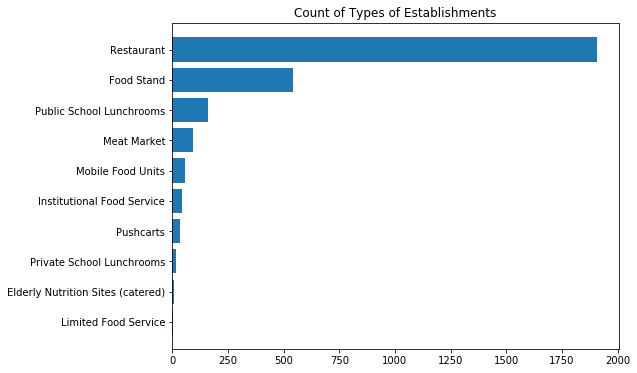

In [10]:
types = df.groupby('type').count()['name'].reset_index(level = 'type')
types = types.sort_values(by = ['name'], ascending = True)
fig = plt.figure(figsize = (8,6))
plt.title('Count of Types of Establishments')
plt.barh(types['type'],types['name'])

It is clear that the most popular type of establishment are Restaurants, followed by Food Stands and Public School Lunchrooms

<BarContainer object of 38 artists>

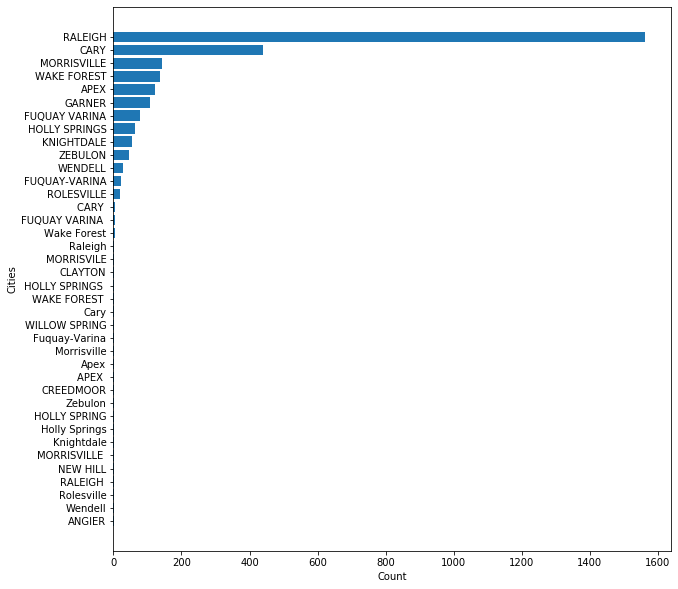

In [29]:
cities = df.groupby('city').count().reset_index(level = 'city')
cities = cities.sort_values(by = 'name', ascending = True)
fig = plt.figure(figsize = (10,10))
plt.title('')
plt.ylabel('Cities')
plt.xlabel('Count')
plt.barh(cities['city'],cities['name'])

The takeaway here is that majority of our data come from once city which may introduce bias to our analysis

<BarContainer object of 3 artists>

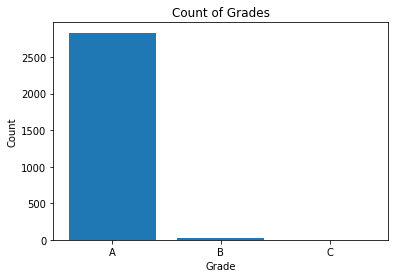

In [30]:
grades = df.groupby('grade').count().reset_index(level = 'grade')
plt.title("Count of Grades")
plt.xlabel('Grade')
plt.ylabel('Count')
plt.bar(grades['grade'],grades['name'])

A large majority of our data fall within the [90, 102] or 'A' category. Since our data is very skewed we may consider regrouping the data into quantiles for more clear interpretation and analysis.

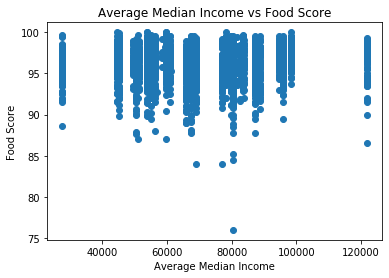

In [31]:
plt.title('Average Median Income vs Food Score')
plt.xlabel('Average Median Income')
plt.ylabel('Food Score')
plt.scatter(df['med_income'],df['score'])

There does not seem to be any clear correlation between median household income and food score

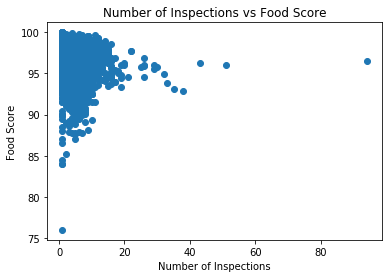

In [32]:
plt.title("Number of Inspections vs Food Score")
plt.xlabel('Number of Inspections')
plt.ylabel('Food Score')
plt.scatter(df['num_insp'],df['score'])

There seems to be a slight positive correlation between the number of inspectors visited with one large outlier and a few less critical outliers. Let's see how this looks without the outlier

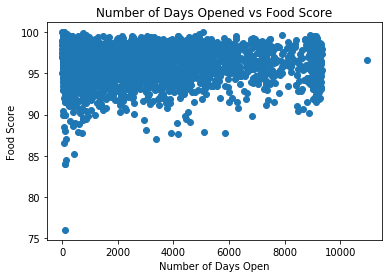

In [33]:
plt.title('Number of Days Opened vs Food Score')
plt.xlabel('Number of Days Open')
plt.ylabel('Food Score')
plt.scatter(df['num_days'],df['score'])

There seems to be a slight positive correlation between number of days open and food score with a few outliers. The distribution of points seems to be rather homoskedastics disregarding the few outliers

## Analysis: Linear Regression Models
Lets statistically investigate the relationships between the variables above

(0.0006672935115205107, 96.21712801391199)

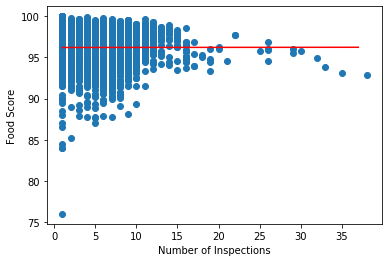

In [34]:
# First, we will investigate the relationship between number of inspections and food score
# we will remove outliers as it will greatly affect our regression

outlier_index = df[df['num_insp']>40].index
new_df = df.drop(index = outlier_index)

a1, b1 = np.polyfit(new_df['num_insp'],new_df['score'],deg = 1)
plt.xlabel('Number of Inspections')
plt.ylabel('Food Score')
plt.scatter(new_df['num_insp'],new_df['score'])
ran = np.arange(min(new_df['num_insp']),max(new_df['num_insp']))
plt.plot(ran, b1+a1*ran,'-',color = 'r'  )
a1,b1

The graph shows that there is little to no correlation between number of inspections and food score. Let's explore another variable

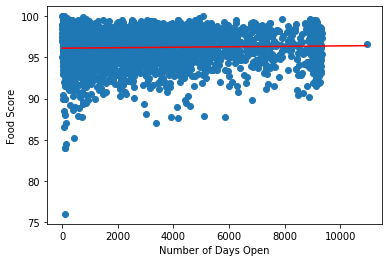

In [35]:
# explore relationship between number of days open and food score
a1, b1 = np.polyfit(new_df['num_days'],new_df['score'],deg = 1)
plt.xlabel('Number of Days Open')
plt.ylabel('Food Score')
plt.scatter(new_df['num_days'],new_df['score'])
ran = np.arange(min(new_df['num_days']),max(new_df['num_days']))
plt.plot(ran, b1+a1*ran,'-',color = 'r'  )

Similarly, there is little to no correlation betwee number of days open and food score.

The variables I've hypothesised to have an influence food score did not actually have an effect on food score. Let's explore a different way to arrive at food score performance based off various factors

## Analysis: Classification Decision Tree
We will now try a classification approach. In order to preform classification we must have a list of predictors and have a desired outcome. As seen previously, we saw that a majority of our data fell in the "A" grade for food scores. I will recategorize the data based off quantiles for a more fine prediction. This new rank will be our outcome variable
- 0 (bad): lowest 1/3 of observations
- 1 (okay) : between 1/3 and 2/3 of observations
- 2 (good) : highest 1/2 of observations 

In [18]:
# we will separate the score variable into three evenly lengthed quantiles
def split_score(num):
    quant1_ub = np.quantile(df['score'],1/3)
    quant2_ub = np.quantile(df['score'],2/3)
    out = None
    if num<quant1_ub:
        out = 0
    elif num<quant2_ub:
        out = 1
    else:
        out = 2
    return out

df['rank'] = df['score'].apply(split_score)

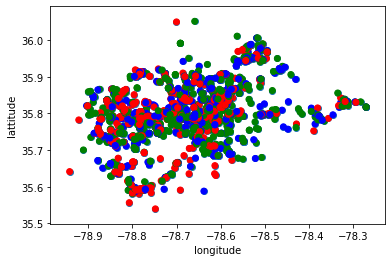

In [38]:
# visualizing the new rank may give us a better idea of the distribution of points

plt.scatter(df['x'],df['y'])
def color_group(rank):
    
    out = None
    if rank == 2:
        out = 'g'
    elif rank == 1:
        out = 'b'
    else:
        out = 'r'
    return out
colors = df['rank'].apply(color_group)
plt.ylabel('lattitude')
plt.xlabel('longitude')
plt.scatter(df['x'],df['y'], c = colors)


In [20]:
train, test = train_test_split(df, test_size = .3)
c = DecisionTreeClassifier(min_samples_split = 5)

In [21]:
features = ['x','y','num_insp','med_income']
target = ['rank']

train_x = train[features]
train_y = train[target]

test_x = test[features]
test_y = test[target]

In [22]:
tr = c.fit(train_x,train_y)

In [23]:
pred_train_y = tr.predict(train_x)
print(classification_report(train_y,pred_train_y))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       689
           1       0.84      0.85      0.84       648
           2       0.91      0.80      0.85       667

    accuracy                           0.85      2004
   macro avg       0.86      0.85      0.85      2004
weighted avg       0.86      0.85      0.85      2004



In [24]:
pred_test_y = tr.predict(test_x)
print(classification_report(test_y,pred_test_y))

              precision    recall  f1-score   support

           0       0.40      0.43      0.41       266
           1       0.37      0.38      0.37       301
           2       0.43      0.39      0.41       293

    accuracy                           0.40       860
   macro avg       0.40      0.40      0.40       860
weighted avg       0.40      0.40      0.40       860



As see in the output above, our training model predicts with accuracy around 85% and our testing model predicts with accuracy around 40%. This tells us the the predictors we chose to explain the output was not fit for prediciton of food score.

## Ethics and Privacy

- **Dataset Privacy**: This dataset, although provided by the professor, is publicly availiable online as the State of North Carolina and similarly all other states. Since we are dealing with establishments rather than individuals we do not invoke the safe harbor method which cleans the data of all personal information. The dataset contains addresses, phone numbers, zip codes and other variables but this should not raise concern as it can be found through search on the internet.
- **Impact**: This dataset only contained information about Wake County of North Carolina. It would be unjustified to extrapolate this data to other states and counties. The results may show that one type of establishment is better fit that the other since it results in a higher health score. This may impact the market in that type of establishment introducing more competition thus lowering revenue for existing establishments. Finally, this analysis may shine more negative light on restaurants that have a low health score. Although publicly availble and displayed on a restaurant, the more exposure a restaurant gets the more it gets ingraned into behavior. As a result this many negatively impact establishments already doing poorly

## Conclusion and Discussion

The goal of this project was to discover factors that may influence food score. The reason why knowing these factors is important is that if the factors are able to be changed for example, location or establishment type, that would increase the overall health score and also promoting a healthier envorionment for the individuals. Contrary to my hypothesis, we found that local income, establishment type and number of previous inspections in fact did not impact health score. A further analysis in classification found that health score cannot be easily predicted and classified. I recommend that further analysis similar to this should consider variables more closely related to an establishment. Although we did not arrive at a set of 
factors that influences health score, we gained alot of knowledge about the distribution of establishments in North Carolina which may help in future research 

### Thank you for reading!